Options Pricing Boundaries Machine Learning Method (Upper-Lower) - (AOP-LB)/(UB-LB)

In [24]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost
import catboost
import optuna

In [25]:
# Reading files from the github repo model with bounds features
columns = ['asset_price', 'maturity', 'rate', 'div', 'ivol', 'european_op', 'american_op', 'lower_bound', 'upper_bound', 'normalized_american_op']

df = pd.read_csv('/Users/nazymazimbayev/Documents/git-projects/dataoptions/DataIn/V3.csv')
df.columns = columns
df = df.drop(['american_op'], axis=1)
df.head()

,asset_price,maturity,rate,div,ivol,european_op,lower_bound,upper_bound,normalized_american_op
0,113.935171,0.285741,0.008467,0.023575,0.538127,6.612110,6.612107,6.612110,0.000000
1,98.305405,0.813916,0.019547,0.018027,0.048863,2.601042,2.613173,2.628241,0.907180
2,109.189731,0.713558,0.022951,0.015280,0.303538,6.397872,6.404801,6.432852,0.924881
3,83.402084,2.879962,0.042272,0.058719,0.163288,20.609465,20.864488,20.905811,0.945361
4,127.549831,0.907992,0.026664,0.017533,0.562713,12.093558,12.108055,12.159764,0.930903


In [26]:
data = df.sample(frac=0.95, random_state=786)
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (95215, 9)
Unseen Data For Predictions (5011, 9)


In [27]:
# Boundaries model 1 with ordinary features data preparation
from pycaret.regression import *
exp_model_dm_rt = setup(data = data, target = 'normalized_american_op', session_id=111, train_size = 0.95, 
                        normalize = True)

,Description,Value
0,session_id,111
1,Target,normalized_american_op
2,Original Data,"(95215, 9)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(90454, 7)"


In [28]:
# Creating a model with ordinary features
top3 = compare_models(n_select = 3, exclude=['et','rf'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.1472,0.0625,0.2501,0.4748,0.1754,0.3914,2.5650
lightgbm,Light Gradient Boosting Machine,0.1512,0.0646,0.2541,0.4578,0.1788,0.4234,1.1280
xgboost,Extreme Gradient Boosting,0.1512,0.0656,0.2561,0.4489,0.1793,0.4074,3.3470
knn,K Neighbors Regressor,0.1365,0.0727,0.2695,0.3898,0.1862,0.4101,0.0870
gbr,Gradient Boosting Regressor,0.1772,0.0738,0.2717,0.3799,0.1918,0.4250,4.3430
lr,Linear Regression,0.2045,0.0854,0.2922,0.2829,0.2052,0.4437,0.6690
ridge,Ridge Regression,0.2045,0.0854,0.2922,0.2829,0.2052,0.4438,0.0210
br,Bayesian Ridge,0.2045,0.0854,0.2922,0.2829,0.2052,0.4438,0.0400
ada,AdaBoost Regressor,0.2378,0.0938,0.3062,0.2125,0.2099,0.5049,0.6020
omp,Orthogonal Matching Pursuit,0.2358,0.1043,0.3230,0.1239,0.2268,0.4986,0.0210


In [29]:
tuned_top3 = [tune_model(i) for i in top3]
blender = blend_models(tuned_top3)
stacker = stack_models(tuned_top3)
best_mae_model = automl(optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1490,0.0631,0.2511,0.4712,0.1769,0.1560
1,0.1481,0.0618,0.2486,0.4740,0.1739,0.1513
2,0.1504,0.0640,0.2529,0.4589,0.1773,0.1547
3,0.1472,0.0632,0.2514,0.4790,0.1770,0.6008
4,0.1448,0.0608,0.2466,0.4729,0.1729,2.1812
5,0.1457,0.0620,0.2490,0.4839,0.1759,0.1206
6,0.1501,0.0642,0.2534,0.4676,0.1777,0.1741
7,0.1455,0.0612,0.2473,0.4888,0.1740,0.1369
8,0.1511,0.0640,0.2531,0.4654,0.1775,0.1477


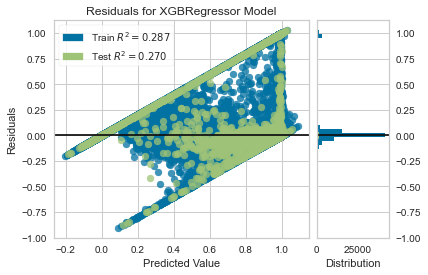

In [30]:
plot_model(best_mae_model)

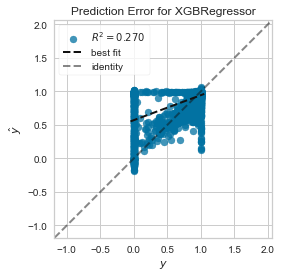

In [31]:
plot_model(best_mae_model, plot = 'error')

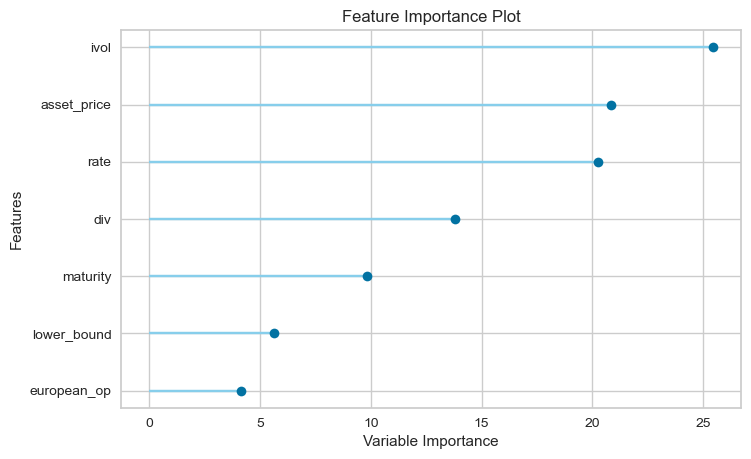

In [32]:
plot_model(top3[0], plot='feature')

In [33]:
print(best_mae_model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=160, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=111, reg_alpha=4, reg_lambda=0.005,
             scale_pos_weight=29.900000000000006, subsample=0.2,
             tree_method='auto', validate_parameters=1, verbosity=0)


In [34]:
save_model(best_mae_model, 'best_mae_model_boundaries_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='normalized_american_op',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 n...
                               interaction_constraints='', learning_rate=0.05,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimato

In [35]:
final_best_model = finalize_model(best_mae_model)
print(final_best_model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=160, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=111, reg_alpha=4, reg_lambda=0.005,
             scale_pos_weight=29.900000000000006, subsample=0.2,
             tree_method='auto', validate_parameters=1, verbosity=0)


In [36]:
predict_model(final_best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.1228,0.0822,0.2867,0.2926,0.2028,0.1003


,asset_price,maturity,rate,div,ivol,european_op,lower_bound,normalized_american_op,Label
0,0.974746,-0.771208,-0.661431,2.272162,0.448551,-1.132289,-1.147461,0.000000,0.984910
1,0.387746,-0.402196,-0.333157,-0.367517,-0.554285,-0.871814,-0.891632,0.937750,0.972117
2,-1.638309,-0.796452,-0.868309,-0.266245,-1.411231,1.352255,1.288337,1.000000,0.899611
3,-0.671752,-0.668805,0.749662,-0.529115,1.539778,0.408394,0.373094,0.903620,0.889749
4,0.836073,-0.504052,2.274875,1.164865,0.591609,-0.751905,-0.769017,0.918518,0.919537
...,...,...,...,...,...,...,...,...,...
4756,1.467124,-0.841321,-1.360488,0.989321,0.102784,-1.432327,-1.441609,1.000000,0.642099
4757,-1.215296,-0.576929,0.614996,2.064034,-2.174488,0.730379,0.678663,0.000000,0.174174
4758,-0.382723,0.404354,-1.352947,0.539229,0.216992,1.056861,0.998733,0.000000,0.990201
4759,0.695367,-0.334968,-1.098904,-0.455906,0.037011,-0.633729,-0.658680,1.000000,0.989315


In [37]:
unseen_predictions = predict_model(final_best_model, data=data_unseen)
unseen_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.1310,0.0895,0.2991,0.2616,0.2107,0.1007


,asset_price,maturity,rate,div,ivol,european_op,lower_bound,upper_bound,normalized_american_op,Label
0,85.411375,0.467677,0.003564,0.097180,0.102791,18.220903,18.220903,18.220904,1.000000,0.852011
1,86.928069,0.701853,0.029514,0.038928,0.018545,13.364723,13.364723,13.364723,0.000000,0.721901
2,106.802615,0.665436,0.007637,0.020037,0.238684,5.340597,5.340597,5.340640,1.000000,0.987480
3,74.557547,0.680546,0.024866,0.002517,0.103077,23.893106,25.442390,25.442546,0.000000,-0.133908
4,113.842459,4.721544,0.025811,0.044534,0.271343,19.143581,19.273635,19.328506,0.970449,0.989313


In [38]:
all_predictions = predict_model(final_best_model, data=df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.1258,0.0857,0.2928,0.2799,0.2069,0.3541


In [40]:
all_predictions['american_op'] = all_predictions['normalized_american_op'] * (all_predictions['upper_bound'] - all_predictions['lower_bound']) + all_predictions['lower_bound']
all_predictions['predicted_american_op'] = all_predictions['Label'] * (all_predictions['upper_bound'] - all_predictions['lower_bound']) + all_predictions['lower_bound']

In [41]:
all_predictions.head()

,asset_price,maturity,rate,div,ivol,european_op,lower_bound,upper_bound,normalized_american_op,Label,american_op,predicted_american_op
0,113.935171,0.285741,0.008467,0.023575,0.538127,6.612110,6.612107,6.612110,0.000000,0.989413,6.612107,6.612110
1,98.305405,0.813916,0.019547,0.018027,0.048863,2.601042,2.613173,2.628241,0.907180,0.815304,2.626842,2.625458
2,109.189731,0.713558,0.022951,0.015280,0.303538,6.397872,6.404801,6.432852,0.924881,0.956140,6.430745,6.431622
3,83.402084,2.879962,0.042272,0.058719,0.163288,20.609465,20.864488,20.905811,0.945361,0.955803,20.903553,20.903984
4,127.549831,0.907992,0.026664,0.017533,0.562713,12.093558,12.108055,12.159764,0.930903,0.951878,12.156191,12.157276


In [42]:
# MSE between columns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print("MSE =", mean_squared_error(all_predictions['american_op'], all_predictions['predicted_american_op']))
print("MAE =", mean_absolute_error(all_predictions['american_op'], all_predictions['predicted_american_op']))

MSE = 0.0029628743155988664
MAE = 0.004591397660838218


In [43]:
#all predictions to csv
all_predictions.to_csv('/Users/nazymazimbayev/Documents/git-projects/dataoptions/DataOut/all_predictions(indirect_method_upper_lower_boundaries).csv')